In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)



In [2]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

In [3]:
def read_dataset(path,col_name,parser):
    """
       path: Time Series dataset path
       col_name: Column name to be given String
       parser: parser function to parse the datetime format
       return: dataframe
    """
    data = pd.read_csv(path,index_col=0,parse_dates=[0],squeeze=True,date_parser=parser)
    data.rename(col_name,inplace=True)
    data = data.asfreq(pd.infer_freq(data.index))
    return data

In [4]:
def plot_data(revised_data,title,yLabel):
    """
        revised_data: dataframe 
        title: title for the plot String
        yLabel: label on Y-axis String 
        return: returns the plot
    """
    plt.figure(figsize=(10,5))
    plt.plot(revised_data)
    plt.title(title, fontsize=20)
    plt.ylabel(yLabel, fontsize=16)
    return plt.show

In [11]:
def dickeyFoolerTest(data):
    """
        data: dataframe 
        returns: ADF statistics and p-value
    """
    test = adfuller(data)
    print("ADF Statistics: %f" %test[0])
    print("p-value: %f" %test[1])
    if test[1] < 0.5:
        print("Time Series is Stationary !!")
    else:
        print("Time Series is Not Stationary !!")

## Read Dataset

In [19]:
url = "https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/catfish.csv"
data = read_dataset(url,'Production',parser)
data.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Freq: MS, Name: Production, dtype: int64

In [20]:
start_date = datetime(2004,1,1)
revised_data = data[start_date:]

<function matplotlib.pyplot.show(close=None, block=None)>

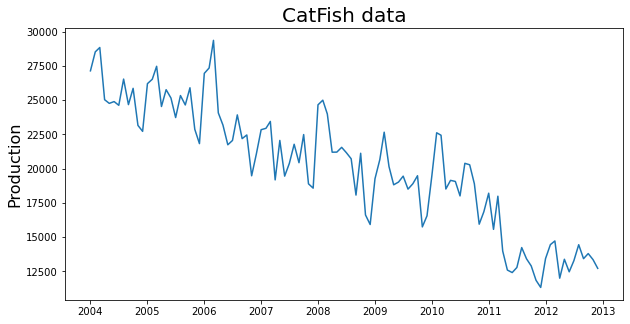

In [23]:
plot_data(revised_data,"CatFish data","Production")

In [22]:
dickeyFoolerTest(revised_data)

ADF Statistics: -0.383338
p-value: 0.912844
Time Series is Not Stationary !!


<function matplotlib.pyplot.show(close=None, block=None)>

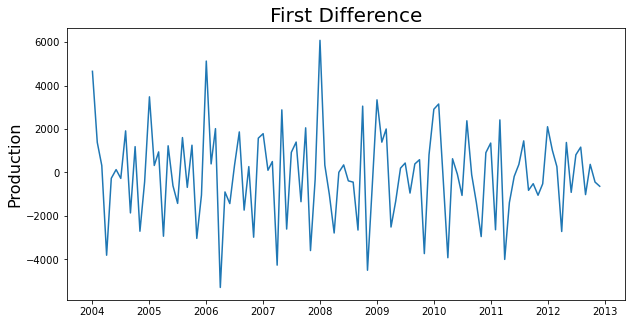

In [32]:
first_diff  = data.diff().dropna()
plot_data(first_diff[start_date:],"First Difference","Production")

In [29]:
dickeyFoolerTest(first_diff[start_date:])

ADF Statistics: -7.260695
p-value: 0.000000
Time Series is Stationary !!


## ACF and PACF 

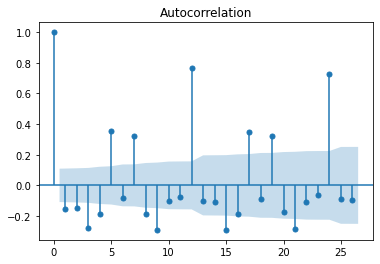

In [26]:
acf_plot = plot_acf(first_diff)

### MA(5),MA(7),MA(9),MA(12),MA(23)

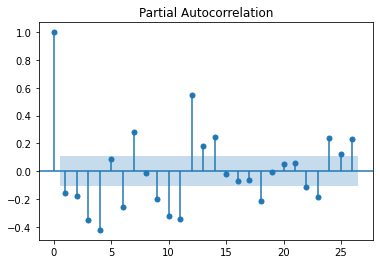

In [27]:
pacf_plot = plot_pacf(first_diff)

### Either AR(3), AR(4) ,AR(10), AR(11) or AR(12)

C:\Users\Omkar\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


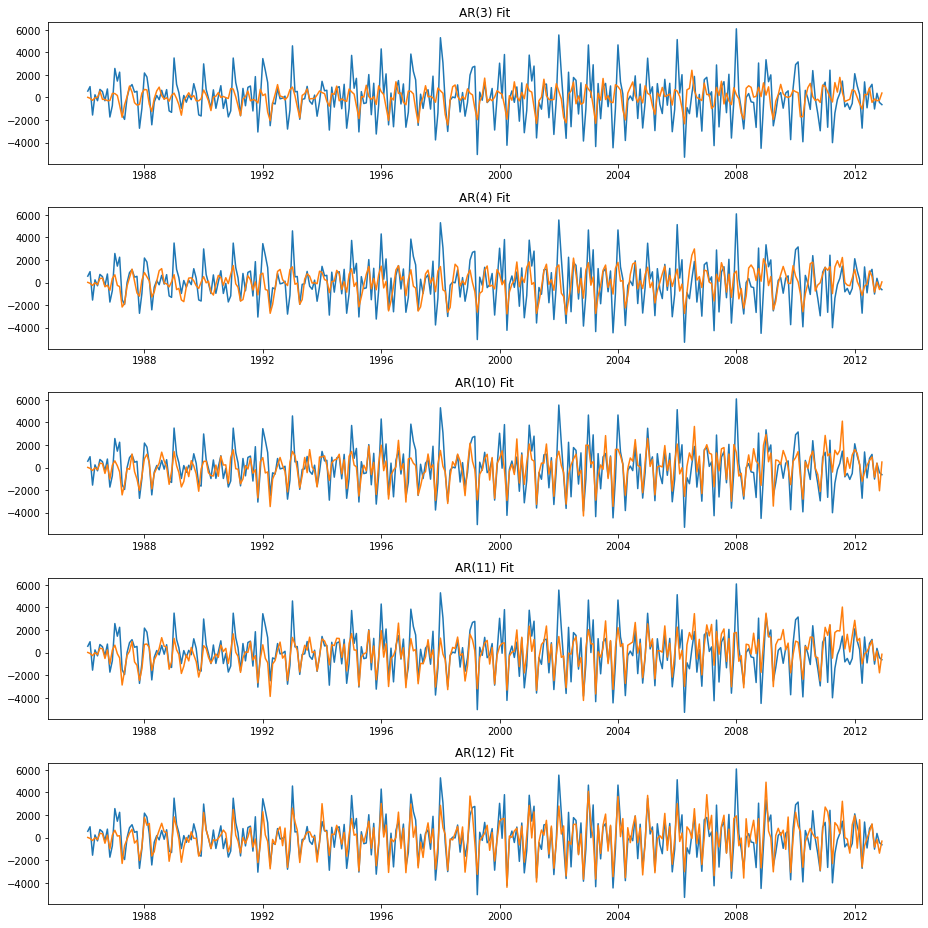

In [54]:
plt.figure(figsize=(13,13))
ar_order = [3,4,10,11,12]
ar_model_save = {}
for id, order in enumerate(ar_order):
    model = ARMA(first_diff,order=(order,0))
    model_fit = model.fit()
    plt.subplot(5,1,id+1)
    plt.plot(first_diff)
    plt.plot(model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%order)
    ar_model_save[order] = model_fit
    
plt.tight_layout()


### AIC and BIC

In [55]:
for order in ar_order:
    print("AIC for AR(%s): %s"%(order,ar_model_save[order].aic))

AIC for AR(3): 5760.372892059442
AIC for AR(4): 5701.787912712144
AIC for AR(10): 5621.741696797199
AIC for AR(11): 5589.160367919577
AIC for AR(12): 5489.722347504627


In [56]:
for order in ar_order:
    print("BIC for AR(%s): %s"%(order,ar_model_save[order].bic))

BIC for AR(3): 5779.261153675556
BIC for AR(4): 5724.45382665148
BIC for AR(10): 5667.073524675871
BIC for AR(11): 5638.269848121471
BIC for AR(12): 5542.609480029744


### From AIC and MIC AR(12) is best model

# MA

C:\Users\Omkar\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Omkar\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Omkar\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


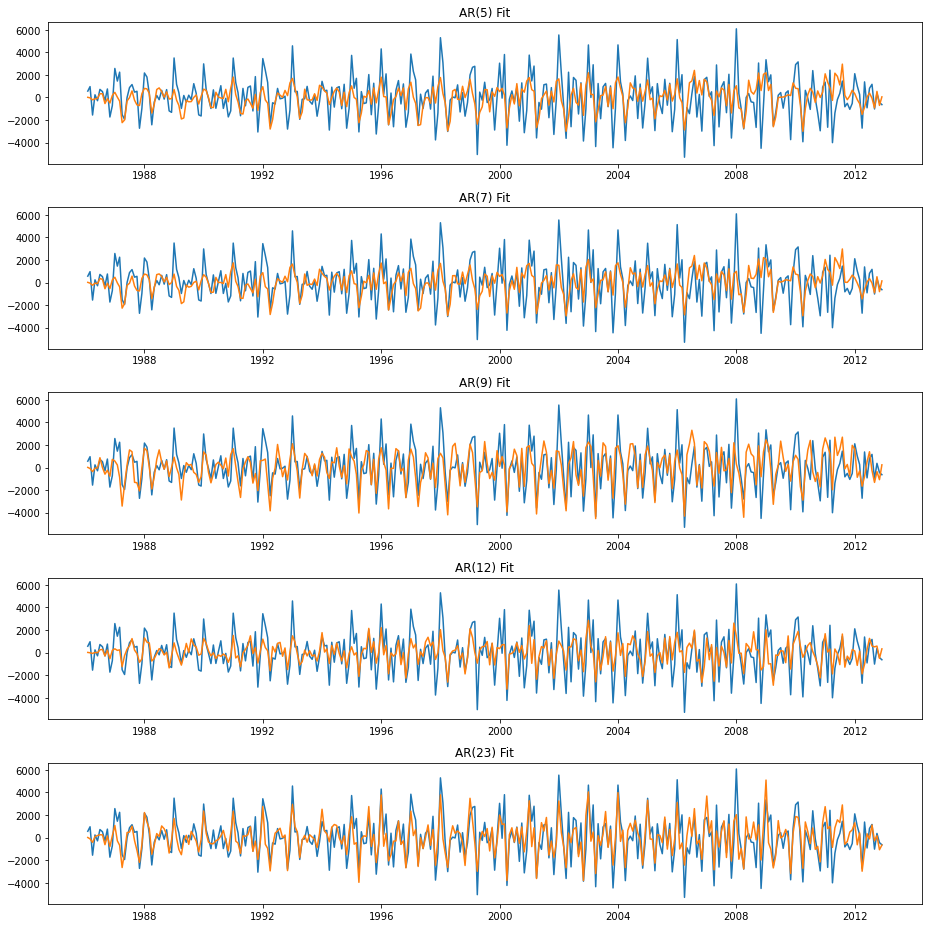

In [57]:
plt.figure(figsize=(13,13))
ma_order = [5,7,9,12,23]
ma_model_save = {}
for id, order in enumerate(ma_order):
    ma_model = ARMA(first_diff,order=(0,order))
    ma_model_fit = ma_model.fit()
    plt.subplot(5,1,id+1)
    plt.plot(first_diff)
    plt.plot(ma_model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%order)
    ma_model_save[order] = ma_model_fit
    
plt.tight_layout()


## AIC and BIC

In [60]:
for order in ma_order:
    print("AIC for MA(%s): %s"%(order,ma_model_save[order].aic))

AIC for MA(5): 5700.775915837233
AIC for MA(7): 5703.675608883168
AIC for MA(9): 5680.417877483765
AIC for MA(12): 5631.547407032057
AIC for MA(23): 5574.8438282685465


In [61]:
for order in ma_order:
    print("BIC for MA(%s): %s"%(order,ma_model_save[order].bic))

BIC for MA(5): 5727.219482099791
BIC for MA(7): 5737.674479792172
BIC for MA(9): 5721.972053039214
BIC for MA(12): 5684.4345395571745
BIC for MA(23): 5669.285136349113


### From AIC and BIC MA(23) is best model with minimum AIC and BIC values 